### Imports

In [1]:
from sklearn.model_selection import train_test_split
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import plotly.express as px
import sys
import numpy as np
import joblib

### Configuration

In [2]:
SEED=42
DESCRIBE_DATASET=False
GENERATE_HEATMAPS=False
CHECK_DUPLICATE_ROWS=False
RUN_ONE_CASE=True
DENSITY_PLOT=False

np.random.seed(42) 

### Load dataset

In [3]:
%%time
dataset = pd.read_csv("../data_preprocessed/everything40.csv",index_col = 0)
dataset = dataset.T

<timed exec>:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,2

CPU times: total: 12.3 s
Wall time: 16.8 s


In [4]:
print("Total samples: ", dataset.shape[0])
print("Total genes  : ", dataset.shape[1])

Total samples:  4778
Total genes  :  13946


### Clean up data

#### Remove unclassified samples:

In [5]:
dataset = dataset[dataset["Classification"] != "no class"]

#### Check for missing values

In [6]:
missing_values = dataset.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
Unnamed: 0
A1BG              0
A2M               0
A2ML1             0
AAAS              0
AACS              0
                 ..
ZYG11B            0
ZYX               0
ZZEF1             0
ZZZ3              0
Classification    0
Length: 13946, dtype: int64


### Dataset overview

#### Column data types

In [7]:
print("Data types:")
print(dataset.dtypes)

Data types:
Unnamed: 0
A1BG              object
A2M               object
A2ML1             object
AAAS              object
AACS              object
                   ...  
ZYG11B            object
ZYX               object
ZZEF1             object
ZZZ3              object
Classification    object
Length: 13946, dtype: object


In [8]:
class_counts = dataset['Classification'].value_counts()

distinct_count = dataset['Classification'].nunique()

In [9]:
print("Total classified samples: ", dataset.shape[0])
print("Total classified genes  : ", dataset.shape[1])
print("Total classes           : ", distinct_count)

Total classified samples:  4679
Total classified genes  :  13946
Total classes           :  75


In [10]:
class_counts

Classification
Exc L2-3 LINC00507 FREM3    681
Exc L5-6 THEMIS C1QL3       459
Exc L3-5 RORB ESR1          423
Exc L4-5 RORB FOLH1B        272
Exc L2 LAMP5 LTK            248
                           ... 
Inh L3-6 SST NPY              4
Inh L1-4 VIP PENK             4
Inh L1-4 VIP CHRNA6           4
Inh L2-5 PVALB SCUBE3         3
Endo L2-6 NOSTRIN             2
Name: count, Length: 75, dtype: int64

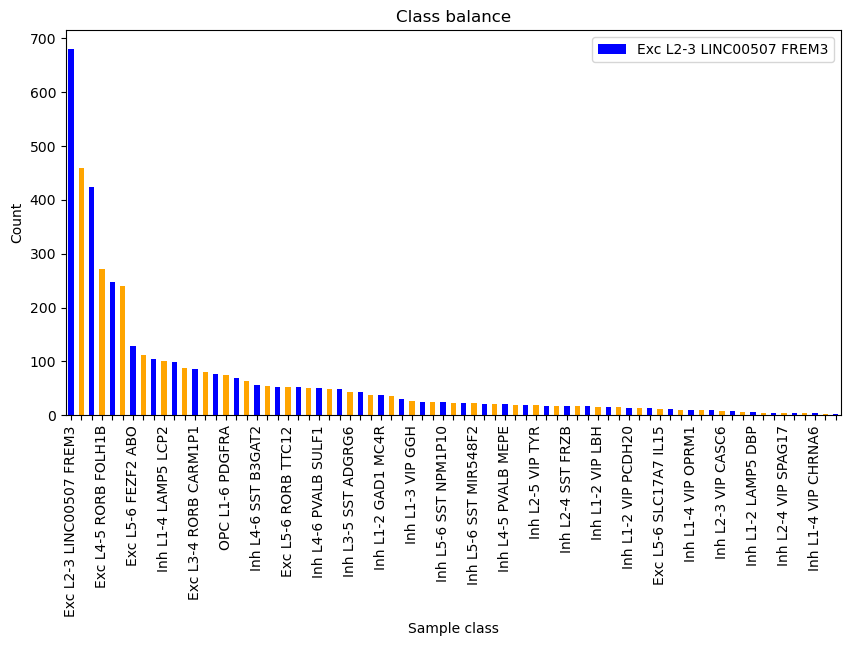

In [11]:
plt.figure(figsize=(10, 5))
bars = class_counts.plot(kind='bar', color=['blue', 'orange'])  
plt.title("Class balance")
plt.xlabel("Sample class")
plt.ylabel("Count")
plt.xticks(rotation=90)

labels = [label if (i % 3 == 0) else '' for i, label in enumerate(class_counts.index)]
bars.set_xticklabels(labels)

top_labels = class_counts.index[:2]  
plt.legend(top_labels)

plt.show()

#### Density Plot

In [12]:

if DENSITY_PLOT:
    features_to_plot = dataset.columns[1:500]

    plt.figure(figsize=(12, 8))
    for feature in features_to_plot:
        dataset[feature].plot(kind='density', label=feature)
        
    plt.title('Sample Density Plot for the first 500 genes')
    plt.xlabel('Expression Level')
    plt.ylabel('Number of cells')
    # plt.legend()
    plt.show()

### Dimensionality reduction

#### Standardization of the data 

This step is performed in order to ensure that each feature contributes equally to the analysis.

In [13]:
features = dataset.iloc[:, :-1]
label = dataset.iloc[:, -1] 

if DESCRIBE_DATASET:
    summary_stats = features.describe()

    print(summary_stats)
else:
    print("Dataset description disabled")

Dataset description disabled


In [14]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(features)

Merge back features and labels:

In [15]:
scaled_df = pd.DataFrame(scaled_data, columns=features.columns)
scaled_df[label.name] = label.values

In [16]:
scaled_df.shape

(4679, 13946)

#### PCA

##### Dimensionality reduction to 3 dimensions

Space 3d: cells x genes (4679, 3)


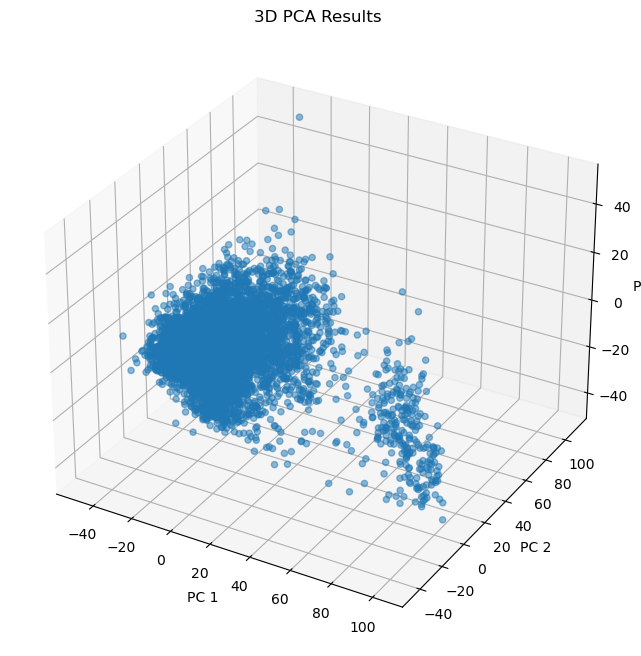

CPU times: total: 2.86 s
Wall time: 1.56 s


In [17]:
%%time
pca_3d = PCA(n_components=3)
pca_data_3d = pca_3d.fit_transform(scaled_data)

pca_df_3d = pd.DataFrame(data=pca_data_3d, columns=['PC1', 'PC2', 'PC3'])

fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(pca_df_3d['PC1'], pca_df_3d['PC2'], pca_df_3d['PC3'], alpha=0.5)

ax.set_title('3D PCA Results')
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')

print("Space 3d: cells x genes", pca_data_3d.shape)

plt.show()

##### Save to disk

In [18]:
dataset.to_csv("../data_preprocessed/everything40_cleaned.csv")

In [19]:
scaled_df.to_csv("../data_preprocessed/everything40_cleaned_normalized.csv")

##### Dimensionality reduction to N dimensions

##### Calculation of explained variance ratio and cumulative explained variance

In [18]:
%%time
pca = PCA()
pca.fit(scaled_data)

explained_variance_ratio = pca.explained_variance_ratio_

print("Calculating cumsum() ...")

cumulative_explained_variance = explained_variance_ratio.cumsum()

Calculating cumsum() ...
CPU times: total: 6min 2s
Wall time: 2min 28s


##### Cumulative Explained Variance Plot

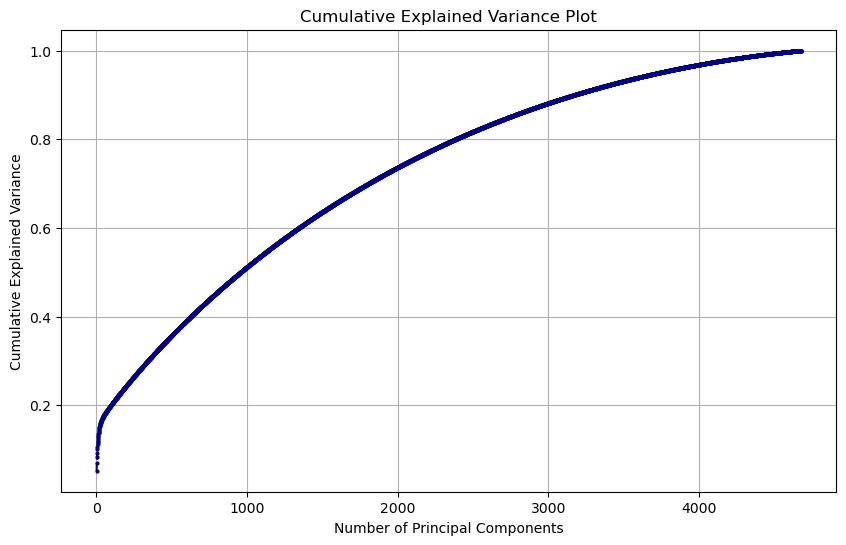

In [19]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--', markersize=2, color='darkblue')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance Plot')
plt.grid(True)
plt.show()


##### Calculate the number of dimensions based on variance

In [22]:
expression_data = scaled_df.drop(columns=['Classification'])

variances = expression_data.var(axis=0)

threshold = np.percentile(variances, 99)

high_variance_genes_count = (variances > threshold).sum()

# Identify the genes with variance above the threshold
high_variance_genes = variances[variances > threshold].index

# Subset the data to include only high variance genes
high_variance_data = expression_data.loc[:, high_variance_genes]

# Scale the high variance data
scaler = StandardScaler()
scaled_high_variance_data = scaler.fit_transform(high_variance_data)

high_variance_genes_count = high_variance_data.shape[1]
print('Number of genes with the highest variance:', high_variance_genes_count)

Number of genes with the highest variance: 138


In [23]:
%%time
pca_nd = PCA(n_components=high_variance_genes_count)
pca_data_nd = pca_nd.fit_transform(scaled_high_variance_data)

reducedDataWithPCA = pca_data_nd

print(reducedDataWithPCA.shape)


(4679, 138)
CPU times: total: 15.6 ms
Wall time: 33 ms


In [24]:
scaled_reduced_df = pd.DataFrame(reducedDataWithPCA)
scaled_reduced_df['Classification'] = scaled_df['Classification'].values

In [25]:
print(scaled_reduced_df.shape)

(4679, 139)


##### Save to disk

In [26]:
scaled_reduced_df.to_csv("../data_preprocessed/everything40_cleaned_normalized_reduced.csv")